# Automated Voigt Species Plots (VSP): SiIV

This code is able to take the component groups and turn it into a csv file that contains all the information about the Veeper fits. It then reduces the pandas data frame to just the fits of the galaxy and runs them through a function that returns the voigt fit and the velocities associated with them to make voigt species plots similar to those seen in Figure 3 of Werk et al. 2013 (https://iopscience.iop.org/article/10.1088/0067-0049/204/2/17/pdf)

Note: This code is meant to be run after the veeper_create-run-collate.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 14

# update various fontsizes to match
params = {'figure.figsize': (18, 12),
          'legend.fontsize': 11,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

import glob
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList

#### Information for each Galaxy/QSO LOS: 
- ##### NGC 3489 / J1101: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101+1429/SamIDs_jess_Nov29_2022.json' 
    - norm = 'J1101+1429_nbin3_jwnorm.fits'
    - Galaxy z: 0.002258
    - QSO z: 0.635
    - V (Helio) [km/s]: 676.9

- ##### NGC 4026 / J1159: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159+5106/SamIDs_meth3_Nov28_2022.json'
    - norm = 'J1159+5106_nbin3_jwnorm_meth3.fits'
    - Galaxy z: 0.003286
    - QSO z: 0.524
    - V (Helio) [km/s]: 985.1
    
- ##### NGC 4736 / J1249: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249+4122/SamIDs_Nov28_2022.json'
    - norm = 'J1249+4122_nbin3_visit12_jwnorm.fits'
    - Galaxy z: 0.001027
    - QSO z: 0.368
    - V (Helio) [km/s]: 307.8
    
- ##### NGC 3414 / 1051: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/SamIDs_Nov29_2022.json'
    - norm = 'J1051+2805_nbin3_jwnorm.fits'
    - Galaxy z: 0.0049
    - QSO z: 0.423
    - V (Helio) [km/s]: 1469.8
    - all_vp_df.loc[(all_vp_df['zsys'] > 0.002) &  (all_vp_df['zsys'] < 0.005) ]
    - specfile = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits'
    
- ##### NGC 3627 / J1123: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123+1257/SamIDs_Nov29_2022.json'
    - norm = 'J1123+1257_nbin3_BASIC_jwnorm.fits'
    - Galaxy z: 0.00243
    - QSO z: 0.315
    - V (Helio) [km/s]: 721

- ##### NGC 1097 / J0246: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246-3007/SamIDs_Nov28_2022.json'
    - norm = 'J0246-3007_nbin3_allvisits_jwnorm.fits'
    - Galaxy z: 0.00424
    - QSO z: 0.524
    - V (Helio) [km/s]: 1271.1

- ##### NGC 4564 / J1235: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235+1123/SamIDs_Nov28_2022.json'
    - norm = 'J1235+1123_twovisits_m3_jwnorm.fits'
    - Galaxy z: 0.003809
    - QSO z: 0.949
    - V (Helio) [km/s]: 1141.9

In [3]:
all_vp_df_J1101 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1101/all_vp.csv')
all_vp_df_J1159 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1159/all_vp.csv')
all_vp_df_J1249 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1249/all_vp.csv')
all_vp_df_J1051 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1051/all_vp.csv')
all_vp_df_J1123 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1123/all_vp.csv')
all_vp_df_J0246 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J0246/all_vp.csv')
all_vp_df_J1235 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1235/all_vp.csv')

In [4]:
#We care about the absorption features that we see around the galaxy so need to input the correct info for each one 
#Used some galaxy criterion to only see the lines that fit what I want to plot 

gal_df_J1101 = all_vp_df_J1101.loc[(all_vp_df_J1101['trans']=='SiIV')] 
gal_df_J1101 

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
11,11,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1393.7602,-0.00017,13.365,0.123,41.9,10.818,38.736,10.086,...,-87.4567,87.4567,1393.116612,1393.929799,248,271,-0.00004,SiIV,b,--
12,12,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1402.7729,-0.00017,13.365,0.000,41.9,0.000,38.736,0.000,...,-87.4567,87.4567,1402.125150,1402.943595,494,516,-0.00004,SiIV,b,--
13,13,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1393.7602,0.00033,12.877,0.373,39.2,27.775,-34.305,26.794,...,-72.2468,72.2468,1393.882657,1394.554419,269,288,0.00021,SiIV,c,--
14,14,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1402.7729,0.00033,12.877,0.000,39.2,0.000,-34.305,0.000,...,-72.2468,72.2468,1402.896148,1403.572255,515,533,0.00021,SiIV,c,--


In [5]:
gal_df_J1159 = all_vp_df_J1159.loc[(all_vp_df_J1159['trans']=='SiIV')]
gal_df_J1159

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
31,31,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1393.7602,-0.00014,13.471,0.035,45.5,4.934,-18.759,3.436,...,-68.4444,68.4444,1393.246243,1393.882650,279,297,-0.00020,SiIV,b,--
32,32,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1402.7729,-0.00014,13.471,0.000,45.5,0.000,-18.759,0.000,...,-68.4444,68.4444,1402.255619,1402.896142,525,542,-0.00020,SiIV,b,--
33,33,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1393.7602,0.00291,12.731,0.124,20.0,10.033,-3.131,6.007,...,-53.6926,53.6926,1397.573139,1398.072381,397,411,0.00290,SiIV,c,--
34,34,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1402.7729,0.00291,12.731,0.000,20.0,0.000,-3.131,0.000,...,-53.6926,53.6926,1406.610495,1407.112966,644,657,0.00290,SiIV,c,--
35,35,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1393.7602,0.00334,13.051,0.089,53.3,14.700,-4.440,9.630,...,-97.3747,97.3747,1397.964328,1398.869735,408,433,0.00333,SiIV,c,--
36,36,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1402.7729,0.00334,13.051,0.000,53.3,0.000,-4.440,0.000,...,-97.3747,97.3747,1407.004214,1407.915475,654,679,0.00333,SiIV,c,--


In [6]:
gal_df_J1249 = all_vp_df_J1249.loc[(all_vp_df_J1249['trans']=='SiIV')]
gal_df_J1249

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
35,35,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1393.7602,-0.00014,13.419,0.051,41.345,6.788,-4.87,4.398,...,-63.3744,63.3744,1393.269813,1393.859079,280,296,-0.00016,SiIV,b,--
36,36,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1402.7729,-0.00014,13.419,0.000,41.345,0.000,-4.87,0.000,...,-63.3744,63.3744,1402.279342,1402.872419,525,542,-0.00016,SiIV,b,--
37,37,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1393.7602,0.00021,13.165,0.076,29.900,7.781,13.28,5.081,...,-40.5596,40.5596,1393.870875,1394.248005,296,307,0.00026,SiIV,c,--
38,38,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1402.7729,0.00021,13.165,0.000,29.900,0.000,13.28,0.000,...,-40.5596,40.5596,1402.884291,1403.263860,542,552,0.00026,SiIV,c,--


In [7]:
gal_df_J1051 = all_vp_df_J1051.loc[(all_vp_df_J1051['trans']=='SiIV')] 
gal_df_J1051 

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
0,0,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00415,13.110,0.068,17.800,4.745,6.094,2.990,...,-52.4764,52.4764,1399.300421,1399.788356,444,458,0.00417,SiIV,c,--
1,1,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00415,13.110,0.000,17.800,0.000,6.094,0.000,...,-52.4764,52.4764,1408.348947,1408.840036,691,704,0.00417,SiIV,c,--
2,2,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00448,13.504,0.035,35.298,4.077,-9.390,2.637,...,-62.9717,62.9717,1399.714496,1400.300017,456,472,0.00445,SiIV,a,--
3,3,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00448,13.504,0.000,35.298,0.000,-9.390,0.000,...,-62.9717,62.9717,1408.765699,1409.355006,702,718,0.00445,SiIV,a,--
26,26,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,-0.00014,13.509,0.045,85.000,10.718,-11.718,7.440,...,-116.6142,116.6142,1393.016987,1394.101285,273,303,-0.00018,SiIV,b,--
27,27,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,-0.00014,13.509,0.000,85.000,0.000,-11.718,0.000,...,-116.6142,116.6142,1402.024881,1403.116191,519,548,-0.00018,SiIV,b,--
28,28,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00635,13.078,0.082,31.300,8.167,14.452,5.565,...,-78.1315,78.1315,1402.240647,1402.967127,524,544,0.00639,SiIV,c,--
29,29,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00635,13.078,0.000,31.300,0.000,14.452,0.000,...,-78.1315,78.1315,1411.308186,1412.039363,772,791,0.00639,SiIV,c,--


In [8]:
gal_df_J1123 = all_vp_df_J1123.loc[(all_vp_df_J1123['trans']=='SiIV')]
gal_df_J1123

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
6,6,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1393.7602,-0.00041,13.484,0.344,72.6,42.884,67.175,46.878,...,-89.6557,89.6557,1392.776123,1393.609756,266,289,-0.00018,SiIV,b,--
7,7,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1402.7729,-0.00041,13.484,0.000,72.6,0.000,67.175,0.000,...,-89.6557,89.6557,1401.782459,1402.621484,512,535,-0.00018,SiIV,b,--
8,8,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1393.7602,0.00019,13.156,0.717,55.6,44.128,-9.340,54.119,...,-83.9085,83.9085,1393.631140,1394.411335,290,311,0.00016,SiIV,b,--
9,9,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1402.7729,0.00019,13.156,0.000,55.6,0.000,-9.340,0.000,...,-83.9085,83.9085,1402.643005,1403.428246,535,557,0.00016,SiIV,b,--


In [9]:
gal_df_J0246 = all_vp_df_J0246.loc[(all_vp_df_J0246['trans']=='SiIV')]
gal_df_J0246

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
19,19,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1393.7602,-0.00088,13.638,0.143,82.598,27.769,50.390,24.069,...,-86.8179,86.8179,1392.131322,1392.938569,249,271,-0.00071,SiIV,c,--
20,20,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1402.7729,-0.00088,13.638,0.000,82.598,0.000,50.390,0.000,...,-86.8179,86.8179,1401.133489,1401.945956,494,516,-0.00071,SiIV,c,--
21,21,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1393.7602,-0.00042,13.759,0.102,28.651,6.398,2.930,3.495,...,-38.3352,38.3352,1393.001475,1393.357922,273,282,-0.00041,SiIV,c,--
22,22,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1402.7729,-0.00042,13.759,0.000,28.651,0.000,2.930,0.000,...,-38.3352,38.3352,1402.009269,1402.368021,518,528,-0.00041,SiIV,c,--
23,23,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1393.7602,0.00002,14.668,0.061,49.500,3.221,-2.800,2.125,...,-80.0528,80.0528,1393.410342,1394.154686,284,304,0.00001,SiIV,b,--
24,24,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1402.7729,0.00002,14.668,0.000,49.500,0.000,-2.800,0.000,...,-80.0528,80.0528,1402.420780,1403.169937,529,550,0.00001,SiIV,b,--
25,25,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1393.7602,0.00045,12.023,1.304,4.000,14.014,-0.057,13.837,...,-43.9727,43.9727,1394.186137,1394.595003,305,316,0.00045,SiIV,c,--
26,26,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1402.7729,0.00045,12.023,0.000,4.000,0.000,-0.057,0.000,...,-43.9727,43.9727,1403.201591,1403.613101,551,562,0.00045,SiIV,c,--


In [10]:
gal_df_J1235 = all_vp_df_J1235.loc[(all_vp_df_J1235['trans']=='SiIV')] 
gal_df_J1235

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
3,3,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235...,1393.7602,-0.00004,13.378,0.061,41.918,8.456,2.961,5.317,...,-59.0440,59.0440,1393.428541,1393.977542,284,299,-0.00003,SiIV,c,--
4,4,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235...,1402.7729,-0.00004,13.378,0.000,41.918,0.000,2.961,0.000,...,-59.0440,59.0440,1402.439097,1402.991648,530,545,-0.00003,SiIV,c,--
5,5,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235...,1393.7602,0.00039,13.082,0.100,17.400,7.033,-18.770,4.300,...,-64.8327,64.8327,1393.999078,1394.601904,300,316,0.00033,SiIV,c,--
6,6,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235...,1402.7729,0.00039,13.082,0.000,17.400,0.000,-18.770,0.000,...,-64.8327,64.8327,1403.013323,1403.620047,545,562,0.00033,SiIV,c,--


In [11]:
#Pull the parts from gal_df that I want/need for the fitting and plots 

#J1101 Values 
trans_J1101 = np.array(gal_df_J1101['trans'])
zsys_J1101 = np.array(gal_df_J1101['zsys'])
N_J1101 = np.array(gal_df_J1101['col'])
b_J1101 = np.array(gal_df_J1101['bval'])
vel_J1101 = np.array(gal_df_J1101['vel'])
wav_J1101 = np.array(gal_df_J1101['restwave'])

#J1159 Values 
trans_J1159 = np.array(gal_df_J1159['trans'])
zsys_J1159 = np.array(gal_df_J1159['zsys'])
N_J1159 = np.array(gal_df_J1159['col'])
b_J1159 = np.array(gal_df_J1159['bval'])
vel_J1159 = np.array(gal_df_J1159['vel'])
wav_J1159 = np.array(gal_df_J1159['restwave'])

#J1249 Values 
trans_J1249 = np.array(gal_df_J1249['trans'])
zsys_J1249 = np.array(gal_df_J1249['zsys'])
N_J1249 = np.array(gal_df_J1249['col'])
b_J1249 = np.array(gal_df_J1249['bval'])
vel_J1249 = np.array(gal_df_J1249['vel'])
wav_J1249 = np.array(gal_df_J1249['restwave'])

#J1051 Values 
trans_J1051 = np.array(gal_df_J1051['trans'])
zsys_J1051 = np.array(gal_df_J1051['zsys'])
N_J1051 = np.array(gal_df_J1051['col'])
b_J1051 = np.array(gal_df_J1051['bval'])
vel_J1051 = np.array(gal_df_J1051['vel'])
wav_J1051 = np.array(gal_df_J1051['restwave'])

#J1123 Values 
trans_J1123 = np.array(gal_df_J1123['trans'])
zsys_J1123 = np.array(gal_df_J1123['zsys'])
N_J1123 = np.array(gal_df_J1123['col'])
b_J1123 = np.array(gal_df_J1123['bval'])
vel_J1123 = np.array(gal_df_J1123['vel'])
wav_J1123 = np.array(gal_df_J1123['restwave'])

#J0246 Values 
trans_J0246= np.array(gal_df_J0246['trans'])
zsys_J0246 = np.array(gal_df_J0246['zsys'])
N_J0246 = np.array(gal_df_J0246['col'])
b_J0246 = np.array(gal_df_J0246['bval'])
vel_J0246 = np.array(gal_df_J0246['vel'])
wav_J0246 = np.array(gal_df_J0246['restwave'])

#J1235 Values 
trans_J1235= np.array(gal_df_J1235['trans'])
zsys_J1235 = np.array(gal_df_J1235['zsys'])
N_J1235 = np.array(gal_df_J1235['col'])
b_J1235 = np.array(gal_df_J1235['bval'])
vel_J1235 = np.array(gal_df_J1235['vel'])
wav_J1235 = np.array(gal_df_J1235['restwave'])

In [12]:
# Define constants

from astropy import constants as const
c = const.c.to('km/s').value #speed of light in km/s for velocity => redshift conversions 

# Load spectrum for plotting
ism = LineList('ISM')

#J1101
specfile_J1101 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101+1429/J1101+1429_nbin3_jwnorm.fits' #normalized spectra file 
xspec_J1101 = lsio.readspec(specfile_J1101)

#J1159
specfile_J1159 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159+5106/J1159+5106_nbin3_jwnorm_meth3.fits' #normalized spectra file 
xspec_J1159 = lsio.readspec(specfile_J1159)

#J1249
specfile_J1249 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249+4122/J1249+4122_nbin3_visit12_jwnorm.fits' #normalized spectra file 
xspec_J1249 = lsio.readspec(specfile_J1249)

#J1051
specfile_J1051 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits' #normalized spectra file 
xspec_J1051 = lsio.readspec(specfile_J1051)

#J1123
specfile_J1123 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123+1257/J1123+1257_nbin3_BASIC_jwnorm.fits' #normalized spectra file 
xspec_J1123 = lsio.readspec(specfile_J1123)

#J0246
specfile_J0246 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246-3007/J0246-3007_nbin3_allvisits_jwnorm.fits' #normalized spectra file 
xspec_J0246 = lsio.readspec(specfile_J0246)

#J1235
specfile_J1235 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235+1123/J1235+1123_twovisits_m3_jwnorm.fits' #normalized spectra file 
xspec_J1235 = lsio.readspec(specfile_J1235)

read_sets: Using set file -- 
  /Users/samgarza/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [13]:
smooth_xspec_J1101 = XSpectrum1D.box_smooth(xspec_J1101, 3)

smooth_xspec_J1159 = XSpectrum1D.box_smooth(xspec_J1159, 3)

smooth_xspec_J1249 = XSpectrum1D.box_smooth(xspec_J1249, 3)

smooth_xspec_J1051 = XSpectrum1D.box_smooth(xspec_J1051, 3)

smooth_xspec_J1123 = XSpectrum1D.box_smooth(xspec_J1123, 3)

smooth_xspec_J0246 = XSpectrum1D.box_smooth(xspec_J0246, 3)

smooth_xspec_J1235 = XSpectrum1D.box_smooth(xspec_J1235, 3)

In [14]:
#Converts wavelengths to velocities 
def convert_wave2vel(obs_wave, rest_wave, LSR_vel=0.):
    # Define constants
    c = const.c.to('km/s').value #has the right value but no units 
    return (((obs_wave - rest_wave)/rest_wave) * c) - LSR_vel #calculates z then * c to makes velocity

#Function to make the bulk of the species plots 
def voigt_species(xspec, redshift, column_density, b_value, restwavelen, LSR): 
    # Set line attributes 
    N = 10**(column_density)/u.km**2  # Column density => Not sure on the units of this 
    b = b_value*u.km/u.s      # Doppler b parameter => Not sure on the units of this => 
    z = redshift            # redshift of absorption feature
    restwav = restwavelen*u.Angstrom

    absline = AbsLine(restwav)  # Initialize AbsLine object
    absline.attrib['N'] = N
    absline.attrib['b'] = b
    absline.setz(z)
    
    # Generate model voigt profiles

    wv_array = xspec.wavelength # Use wavelength array from the spectrum you loaded

    voigt = absline.generate_voigt(wave=wv_array)
    
    vels = convert_wave2vel(wv_array, restwav, LSR_vel=LSR) #This LSR_vel changes for each galaxy/QSO LOS 
    
    return voigt, vels

In [15]:
#This is the actually automated part and this makes life so much easier 

LSR_values = np.array([676.9, 985.1, 307.8, 1469.8, 721, 1271.1, 1141.9])

#J1101
Voigt_J1101 = []
Vels_J1101 = []
Voigt_smooth_J1101 = []
Vels_smooth_J1101 = []

for i in range(len(trans_J1101)): 
    vo, ve = voigt_species(xspec_J1101, zsys_J1101[i], N_J1101[i], b_J1101[i], wav_J1101[i], LSR_values[0])
    VO, VE = voigt_species(smooth_xspec_J1101, zsys_J1101[i], N_J1101[i], b_J1101[i], wav_J1101[i], LSR_values[0])
    
    Voigt_J1101.append(vo)
    Vels_J1101.append(ve)
    Voigt_smooth_J1101.append(VO)
    Vels_smooth_J1101.append(VE)
    
#J1159
Voigt_J1159 = []
Vels_J1159 = []
Voigt_smooth_J1159 = []
Vels_smooth_J1159 = []

for i in range(len(trans_J1159)): 
    vo, ve = voigt_species(xspec_J1159, zsys_J1159[i], N_J1159[i], b_J1159[i], wav_J1159[i], LSR_values[1])
    VO, VE = voigt_species(smooth_xspec_J1159, zsys_J1159[i], N_J1159[i], b_J1159[i], wav_J1159[i], LSR_values[1])
   
    Voigt_J1159.append(vo)
    Vels_J1159.append(ve)
    Voigt_smooth_J1159.append(VO)
    Vels_smooth_J1159.append(VE)
    
#J1249
Voigt_J1249 = []
Vels_J1249 = []
Voigt_smooth_J1249 = []
Vels_smooth_J1249 = []

for i in range(len(trans_J1249)): 
    vo, ve = voigt_species(xspec_J1249, zsys_J1249[i], N_J1249[i], b_J1249[i], wav_J1249[i], LSR_values[2])
    VO, VE = voigt_species(smooth_xspec_J1249, zsys_J1249[i], N_J1249[i], b_J1249[i], wav_J1249[i], LSR_values[2])
   
    Voigt_J1249.append(vo)
    Vels_J1249.append(ve)
    Voigt_smooth_J1249.append(VO)
    Vels_smooth_J1249.append(VE)

#J051
Voigt_J1051 = []
Vels_J1051 = []
Voigt_smooth_J1051 = []
Vels_smooth_J1051 = []

for i in range(len(trans_J1051)): 
    vo, ve = voigt_species(xspec_J1051, zsys_J1051[i], N_J1051[i], b_J1051[i], wav_J1051[i], LSR_values[3])
    VO, VE = voigt_species(smooth_xspec_J1051, zsys_J1051[i], N_J1051[i], b_J1051[i], wav_J1051[i], LSR_values[3])
    
    Voigt_J1051.append(vo)
    Vels_J1051.append(ve)
    Voigt_smooth_J1051.append(VO)
    Vels_smooth_J1051.append(VE)
    
#J1123
Voigt_J1123 = []
Vels_J1123 = []
Voigt_smooth_J1123 = []
Vels_smooth_J1123 = []

for i in range(len(trans_J1123)): 
    vo, ve = voigt_species(xspec_J1123, zsys_J1123[i], N_J1123[i], b_J1123[i], wav_J1123[i], LSR_values[4])
    VO, VE = voigt_species(smooth_xspec_J1123, zsys_J1123[i], N_J1123[i], b_J1123[i], wav_J1123[i], LSR_values[4])
    
    Voigt_J1123.append(vo)
    Vels_J1123.append(ve)
    Voigt_smooth_J1123.append(VO)
    Vels_smooth_J1123.append(VE)
    
#J0246
Voigt_J0246 = []
Vels_J0246 = []
Voigt_smooth_J0246 = []
Vels_smooth_J0246 = []

for i in range(len(trans_J0246)): 
    vo, ve = voigt_species(xspec_J0246, zsys_J0246[i], N_J0246[i], b_J0246[i], wav_J0246[i], LSR_values[5])
    VO, VE = voigt_species(smooth_xspec_J0246, zsys_J0246[i], N_J0246[i], b_J0246[i], wav_J0246[i], LSR_values[5])
    
    Voigt_J0246.append(vo)
    Vels_J0246.append(ve)
    Voigt_smooth_J0246.append(VO)
    Vels_smooth_J0246.append(VE)
    
#J1235
Voigt_J1235 = []
Vels_J1235 = []
Voigt_smooth_J1235 = []
Vels_smooth_J1235 = []

for i in range(len(trans_J1235)): 
    vo, ve = voigt_species(xspec_J1235, zsys_J1235[i], N_J1235[i], b_J1235[i], wav_J1235[i], LSR_values[6])
    VO, VE = voigt_species(smooth_xspec_J1235, zsys_J1235[i], N_J1235[i], b_J1235[i], wav_J1235[i], LSR_values[6])
    
    Voigt_J1235.append(vo)
    Vels_J1235.append(ve)
    Voigt_smooth_J1235.append(VO)
    Vels_smooth_J1235.append(VE)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


/Users/samgarza/linetools/linetools/analysis/voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:244: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:245: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on 

In [16]:
#labels for each feature

#J1101
labels_J1101 = []
for i in range(len(trans_J1101)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1101.append((trans_J1101[i], wav_J1101[i], zsys_J1101[i], N_J1101[i], b_J1101[i]))

#J1159
labels_J1159 = []
for i in range(len(trans_J1159)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1159.append((trans_J1159[i], wav_J1159[i], zsys_J1159[i], N_J1159[i], b_J1159[i]))

#J1249
labels_J1249 = []
for i in range(len(trans_J1249)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1249.append((trans_J1249[i], wav_J1249[i], zsys_J1249[i], N_J1249[i], b_J1249[i]))

#J1051
labels_J1051 = []
for i in range(len(trans_J1051)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1051.append((trans_J1051[i], wav_J1051[i], zsys_J1051[i], N_J1051[i], b_J1051[i]))

#J1123
labels_J1123 = []
for i in range(len(trans_J1123)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1123.append((trans_J1123[i], wav_J1123[i], zsys_J1123[i], N_J1123[i], b_J1123[i]))
    
#J0246
labels_J0246 = []
for i in range(len(trans_J0246)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J0246.append((trans_J0246[i], wav_J0246[i], zsys_J0246[i], N_J0246[i], b_J0246[i]))
    
#J1235
labels_J1235 = []
for i in range(len(trans_J1235)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1235.append((trans_J1235[i], wav_J1235[i], zsys_J1235[i], N_J1235[i], b_J1235[i]))
labels_J1235

[('SiIV', 1393.7602, -4e-05, 13.378, 41.918),
 ('SiIV', 1402.7729, -4e-05, 13.378, 41.918),
 ('SiIV', 1393.7602, 0.00039, 13.082, 17.4),
 ('SiIV', 1402.7729, 0.00039, 13.082, 17.4)]

In [42]:
#VSP for each galaxy 

#J1101
def J1101_vsp(xspec, Vels, Voigt): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)

    #SiIV 1393 (0, 2)
    axs[0].step(Vels[0], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-800, -450, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels[0]+vel_J1101[0], Voigt[0].flux, c='silver', lw=3, label = labels_J1101[0])  
    axs[0].plot(Vels[2]+vel_J1101[2], Voigt[2].flux, c='silver', lw=3, label = labels_J1101[2]) 
    #axs[0].plot(Vels_J1101[4]+vel_J1101[4], Voigt_J1101[4].flux, c='deepskyblue', lw=3, label = labels_J1101[4] )
    axs[0].plot(Vels[0], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-900,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy (NGC 3489): z = 0.002258, b = 110.0, log$M_{*}$=10.2$M_{\odot}$, log$M_{BH}$ = 6.77$M_{\odot}$; QSO: J1101+1429, z = 0.6359', fontsize=15)
    axs[0].legend(loc=4)

    #SiIV 1402 (1, 3)
    axs[1].step(Vels[1], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-800, -450, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels[1]+vel_J1101[1], Voigt[1].flux, c='silver', lw=3, label = labels_J1101[1]) 
    axs[1].plot(Vels[3]+vel_J1101[3], Voigt[3].flux, c='silver', lw=3, label = labels_J1101[3]) 
    #axs[1].plot(Vels_J1101[5]+vel_J1101[5], Voigt_J1101[5].flux, c='deepskyblue', lw=3, label = labels_J1101[5] )
    axs[1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-900,200)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    
#################################################################
    
#J1159
def J1159_vsp(xspec, Vels, Voigt): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)

    #SiIV 1393 (0, 2, 4)
    axs[0].step(Vels[0], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-1200, -900, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels[0]+vel_J1159[0], Voigt[0].flux, c='silver', lw=3) 
    axs[0].plot(Vels[2]+vel_J1159[2], Voigt[2].flux, c='violet', lw=3, label = labels_J1159[2]) 
    axs[0].plot(Vels[4]+vel_J1159[4], Voigt[4].flux, c='violet', lw=3, label = labels_J1159[4]) 
    axs[0].plot(Vels[0], xspec_J1159.sig/xspec.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-1400,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy (NGC 4026): z = 0.003286, b = 37.38, log$M_{*}$ = 10.43$M_{\odot}$, log$M_{BH}$ = 8.25$M_{\odot}$; QSO: J1159+5106, z = 0.524',fontsize=15)
    axs[0].legend(loc=4)

    #SiIV 1402 (1, 3, 5)
    axs[1].step(Vels[1], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-1200, -900, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels[1]+vel_J1159[1], Voigt[1].flux, c='silver', lw=3)
    axs[1].plot(Vels[3]+vel_J1159[3], Voigt[3].flux, c='violet', lw=3, label = labels_J1159[3]) 
    axs[1].plot(Vels[5]+vel_J1159[5], Voigt[5].flux, c='violet', lw=3, label = labels_J1159[5]) 
    axs[1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-1400,200)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')

#################################################################

#J1249
def J1249_vsp(xspec, Vels, Voigt): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)

    #SiIV 1393 (0 ,2)
    axs[0].step(Vels[0], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-450, -150, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels[0]+vel_J1249[0], Voigt[0].flux, c='silver', lw=3,  label = labels_J1249[0] )  
    axs[0].plot(Vels[2]+vel_J1249[2], Voigt[2].flux, c='silver', lw=3,  label = labels_J1249[2] )    
    axs[0].plot(Vels[0], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-700,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy (NGC 4736): z = 0.001027, b = 25.52, log$M_{*}$ = 10.62$M_{\odot}$, log$M_{BH}$ = 6.83$M_{\odot}$; QSO: J1249+4122, z = 0.3682',fontsize=15)
    axs[0].legend(loc=4)

    #SiIV 1402 (1, 3)
    axs[1].step(Vels[1], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-450, -150, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels[1]+vel_J1249[1], Voigt[1].flux, c='silver', lw=3, label = labels_J1249[1]) 
    axs[1].plot(Vels[3]+vel_J1249[3], Voigt[3].flux, c='silver', lw=3, label = labels_J1249[3])  
    axs[1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-700,200)
    axs[1].set_ylim(0,1.2)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    axs[1].legend(loc=4)

#################################################################

#J1051
def J1051_vsp(xspec, Vels, Voigt): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)

    #SiIV 1393 (0, 2, 4, 6)
    axs[0].step(Vels[0], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-1700, -1250, alpha = 0.35, color = 'lightgrey')
    #axs[0].plot(Vels[0]+vel_J1051[0], Voigt[0].flux, c='violet', lw=3, label = labels_J1051[0])  
    axs[0].plot(Vels[2]+vel_J1051[2], Voigt[2].flux, c='violet', lw=3, label = labels_J1051[2]) 
    axs[0].plot(Vels[4]+vel_J1051[4], Voigt[4].flux, c='silver', lw=3) 
    axs[0].plot(Vels[6]+vel_J1051[6], Voigt[6].flux, c='silver', lw=3) 
    axs[0].plot(Vels[0], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-1800,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy (NGC 3414): z = 0.0049, b = 40.499, log$M_{*}$ = 10.8$M_{\odot}$, log$M_{BH}$ = 8.40$M_{\odot}$; QSO: J1051+2805, z = 0.423', fontsize=15)
    axs[0].legend(loc=4)

    #SiIV 1402 (1, 3, 5, 7)
    axs[1].step(Vels[1], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-1700, -1250, alpha = 0.35, color = 'lightgrey')
    #axs[1].plot(Vels[1]+vel_J1051[1], Voigt[1].flux, c='violet', lw=3, label = labels_J1051[1])
    axs[1].plot(Vels[3]+vel_J1051[3], Voigt[3].flux, c='violet', lw=3, label = labels_J1051[3])
    axs[1].plot(Vels[5]+vel_J1051[5], Voigt[5].flux, c='silver', lw=3)
    axs[1].plot(Vels[7]+vel_J1051[7], Voigt[7].flux, c='silver', lw=3)
    axs[1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-1800,200)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    
#################################################################
    
#J1123
def J1123_vsp(xspec, Vels, Voigt): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)

    #SiIV 1393 (0,2)
    axs[0].step(Vels[0], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-900, -575, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels[0]+vel_J1123[0], Voigt[0].flux, c='silver', lw=3, label = labels_J1123[0]) 
    axs[0].plot(Vels[2]+vel_J1123[2], Voigt[2].flux, c='silver', lw=3, label = labels_J1123[2]) 
    axs[0].plot(Vels[0], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-1000,400)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy (NGC 3627): z = 0.00243, b = 119.976, log$M_{*}$ = 10.84$M_{\odot}$,log$M_{BH}$ = 6.92$M_{\odot}$; QSO: J1123+1257, z = 0.315',fontsize=15)
    axs[0].legend(loc=4)

    #SiIV 1402 (1,3)
    axs[1].step(Vels[1], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-900, -575, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels[1]+vel_J1123[1], Voigt[1].flux, c='silver', lw=3, label = labels_J1123[1])
    axs[1].plot(Vels[3]+vel_J1123[3], Voigt[3].flux, c='silver', lw=3, label = labels_J1123[3]) 
    axs[1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-1000,400)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    
#################################################################
    
#J0246
def J0246_vsp(xspec, Vels, Voigt): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)

    #SiIV 1393 (0, 2, 4, 6)
    axs[0].step(Vels[0], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-1650, -1150, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels[0]+vel_J0246[0], Voigt[0].flux, c='silver', lw=3, label = labels_J0246[0]) 
    axs[0].plot(Vels[2]+vel_J0246[2], Voigt[2].flux, c='silver', lw=3, label = labels_J0246[2])
    axs[0].plot(Vels[4]+vel_J0246[4], Voigt[4].flux, c='silver', lw=3, label = labels_J0246[4])
    axs[0].plot(Vels[6]+vel_J0246[6], Voigt[6].flux, c='silver', lw=3, label = labels_J0246[6])
    axs[0].plot(Vels[0], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-1900,300)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy (NGC 1097): z = 0.00424, b = 55.66, log$M_{*}$ = 10.5$M_{\odot}$, log$M_{BH}$ = 8.14$M_{\odot}$; QSO: J0246-3007, z = 0.524',fontsize=15)
    axs[0].legend(loc=4)

    #SiIV 1402 (1, 3, 5, 7)
    axs[1].step(Vels[1], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-1650, -1150, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels[1]+vel_J0246[1], Voigt[1].flux, c='silver', lw=3, label = labels_J0246[1])
    axs[1].plot(Vels[3]+vel_J0246[3], Voigt[3].flux, c='silver', lw=3, label = labels_J0246[3])
    axs[1].plot(Vels[5]+vel_J0246[5], Voigt[5].flux, c='silver', lw=3, label = labels_J0246[5])
    axs[1].plot(Vels[7]+vel_J0246[7], Voigt[7].flux, c='silver', lw=3, label = labels_J0246[7])
    axs[1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-1900,300)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    
#################################################################
    
#J1235
def J1235_vsp(xspec, Vels, Voigt): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)

    #SiIV 1393 (0, 2)
    axs[0].step(Vels[0], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-1250, -1000, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels[0]+vel_J1235[0], Voigt[0].flux, c='silver', lw=3, label = labels_J1235[0])
    axs[0].plot(Vels[2]+vel_J1235[2], Voigt[2].flux, c='silver', lw=3, label = labels_J1235[2]) 
    axs[0].plot(Vels[0], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-1500,300)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy (NGC 4564): z = 0.0038, b = 123.08, log$M_{*}$ = 10.4$M_{\odot}$, log$M_{BH}$ = 7.94$M_{\odot}$; QSO: LBQS-1235+1123, z = 0.949',fontsize=15)
    axs[0].legend(loc=4)

    #SiIV 1402 (1, 3)
    axs[1].step(Vels[1], xspec.flux/xspec.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-1250, -1000, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels[1]+vel_J1235[1], Voigt[1].flux, c='silver', lw=3, label = labels_J1235[1])
    axs[1].plot(Vels[3]+vel_J1235[3], Voigt[3].flux, c='silver', lw=3, label = labels_J1235[3])
    axs[1].plot(Vels[1], xspec.sig/xspec.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-1500,300)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')

## VSP for Each Galaxy/QSO LOS

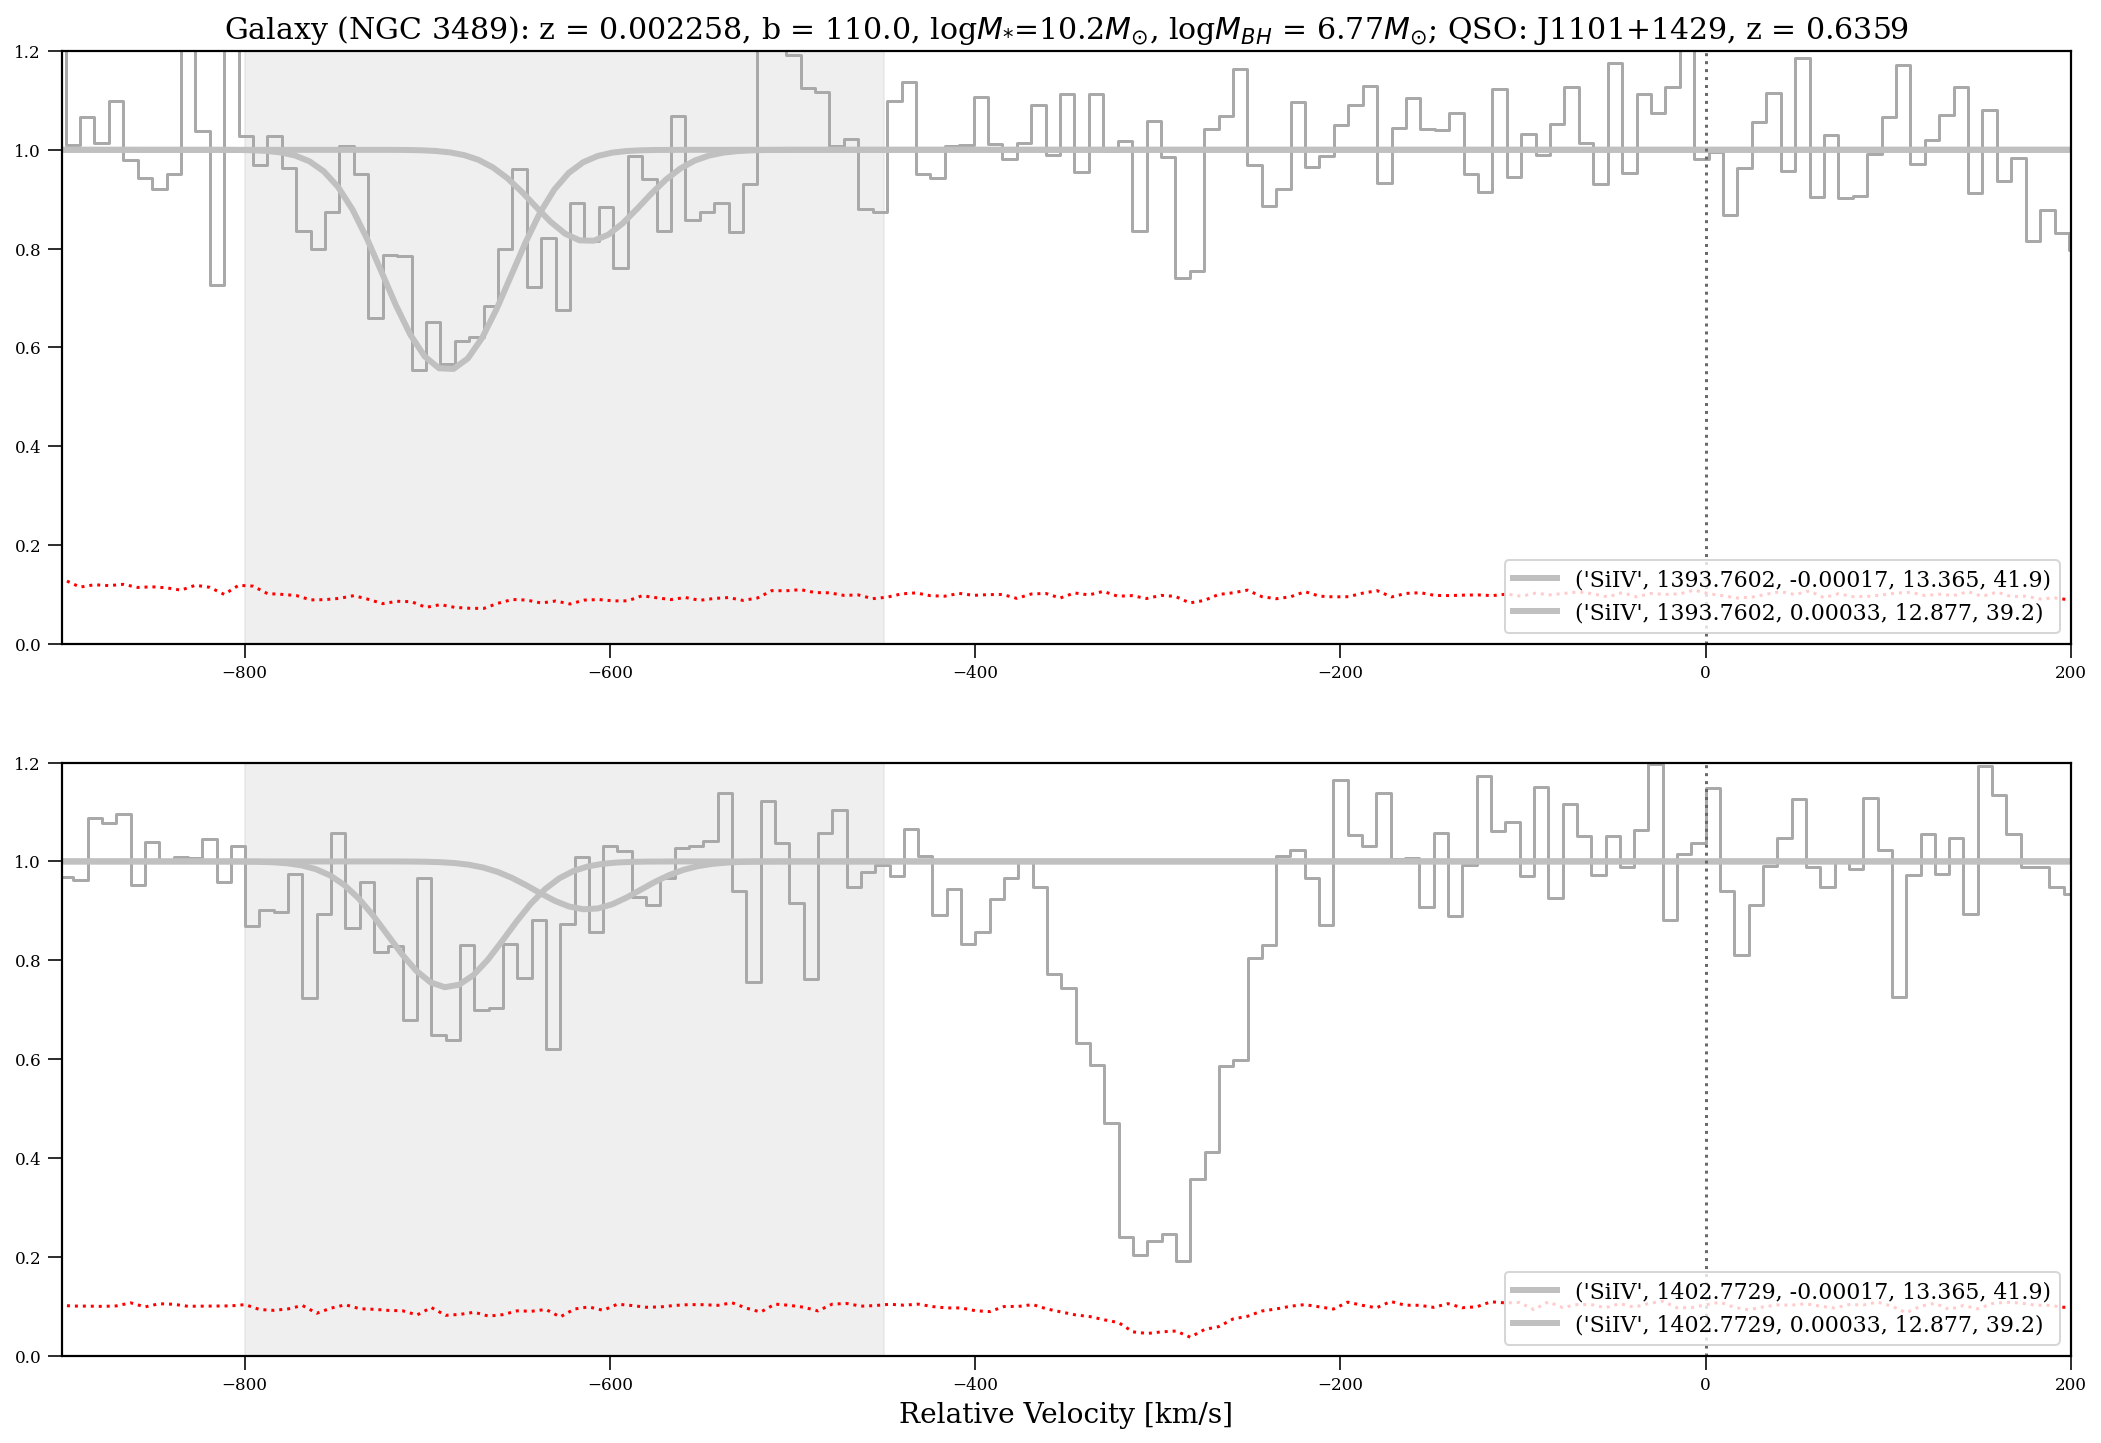

In [43]:
# J1101 - Unsmoothed Spectra 
J1101_vsp(xspec_J1101, Vels_J1101, Voigt_J1101) #it looks fine after checking pyigm 
# J1101 - Smoothed Spectra 
#J1101_vsp(smooth_xspec_J1101, Vels_smooth_J1101, Voigt_smooth_J1101) #it looks fine after checking pyigm 

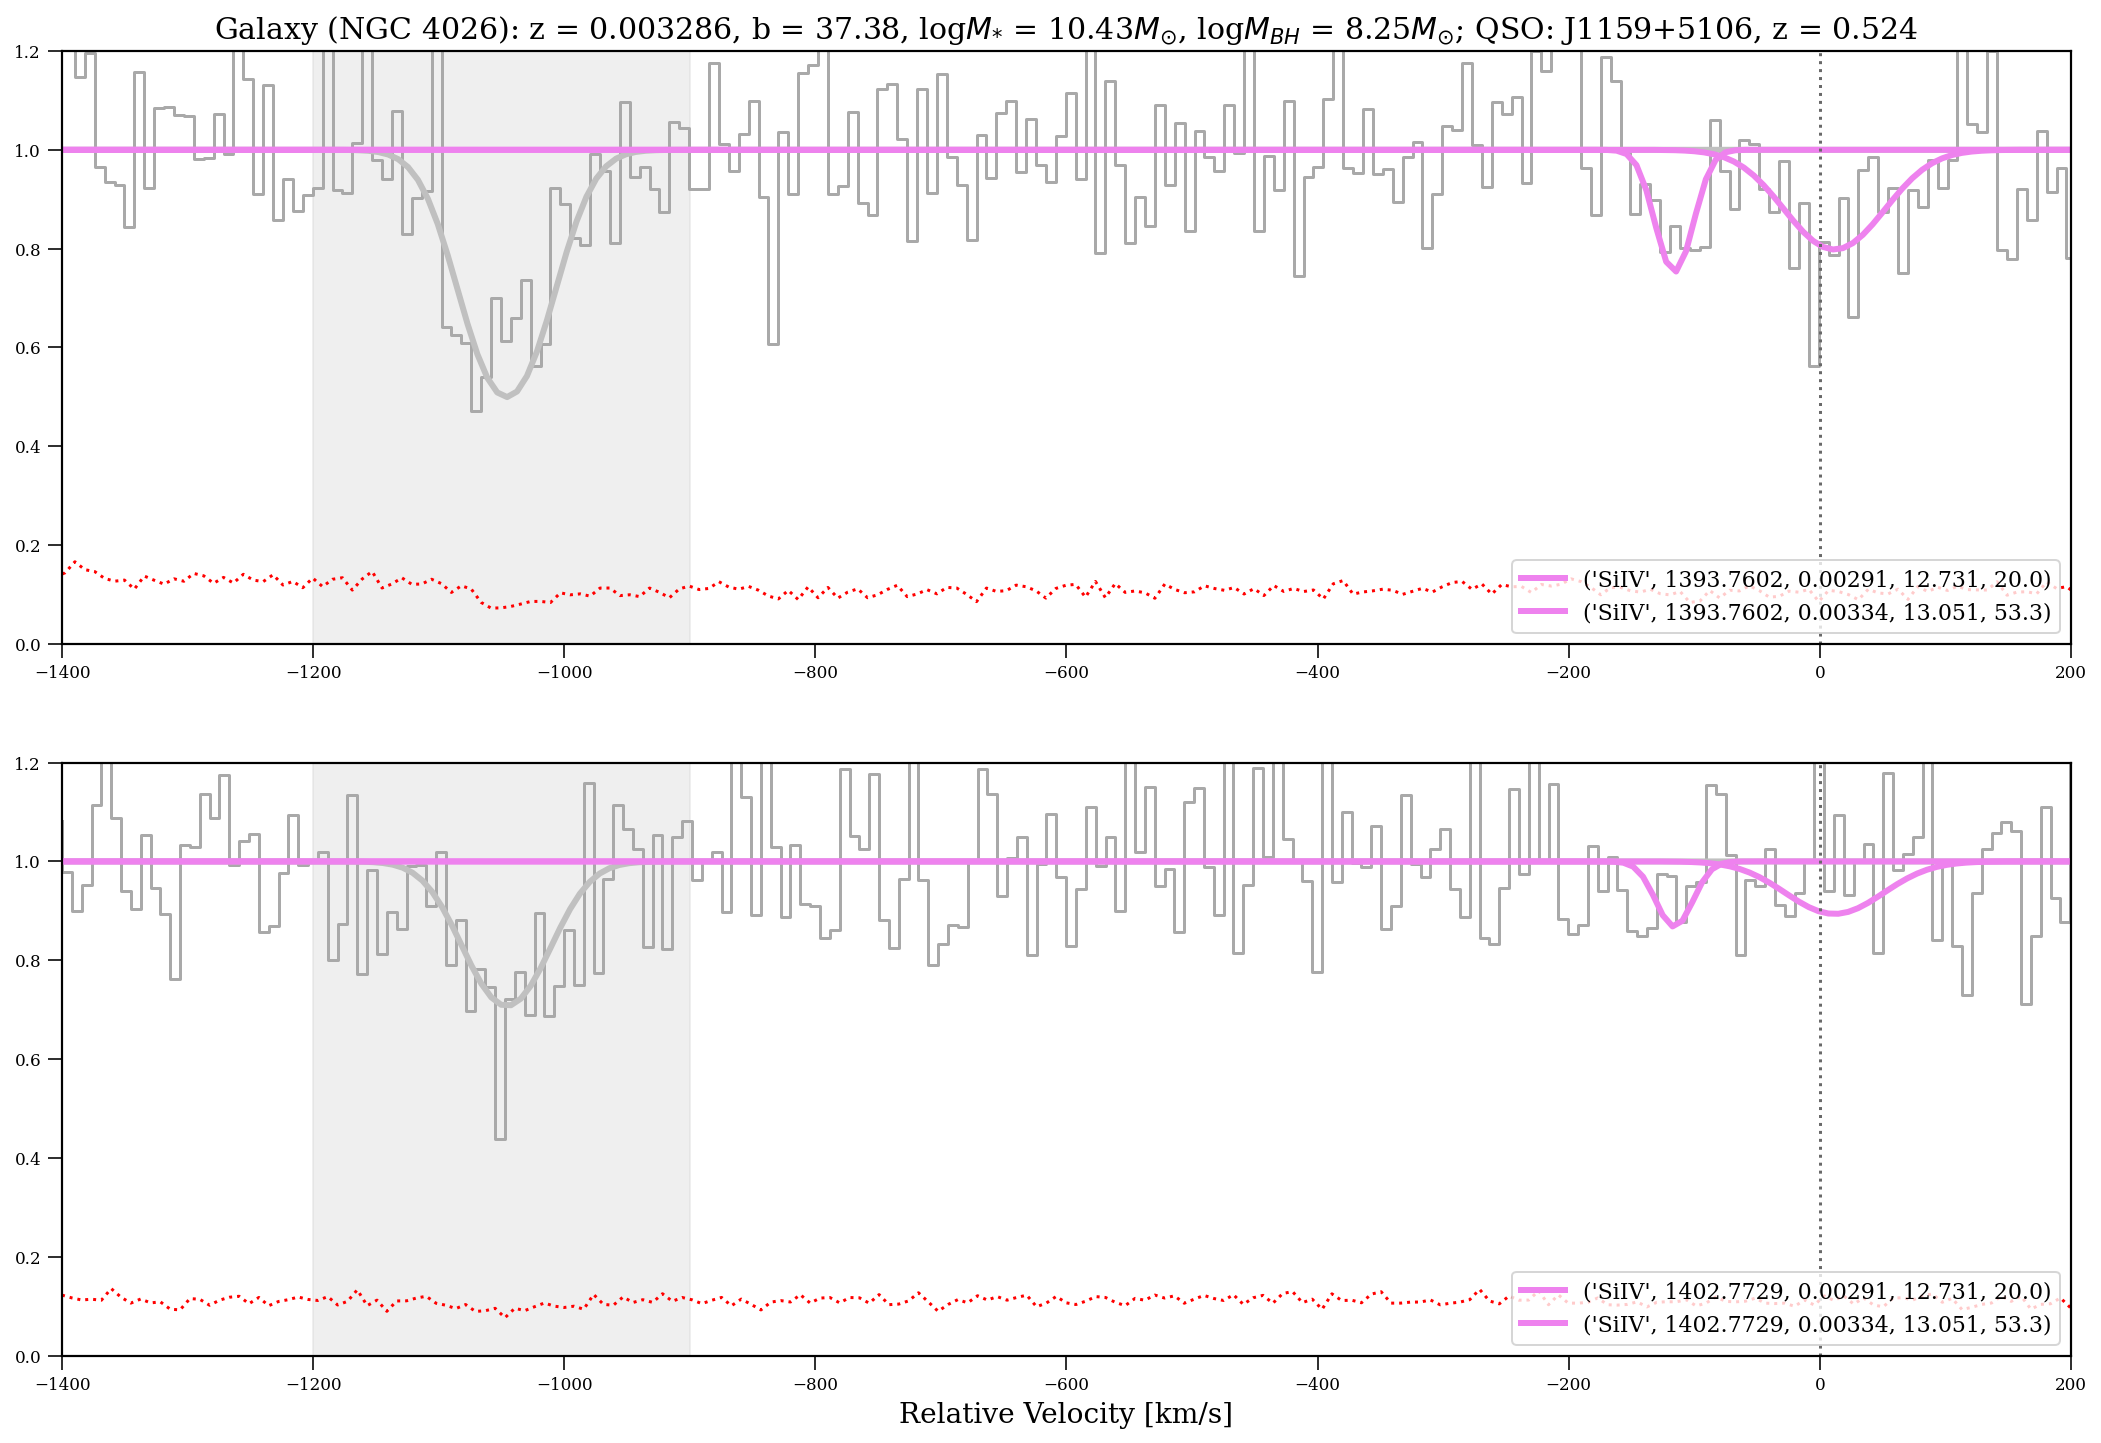

In [44]:
# J159 - Unsmoothed Spectra 
J1159_vsp(xspec_J1159, Vels_J1159, Voigt_J1159) 
# J159 - Smoothed Spectra 
#J1159_vsp(smooth_xspec_J1159, Vels_smooth_J1159, Voigt_smooth_J1159) 

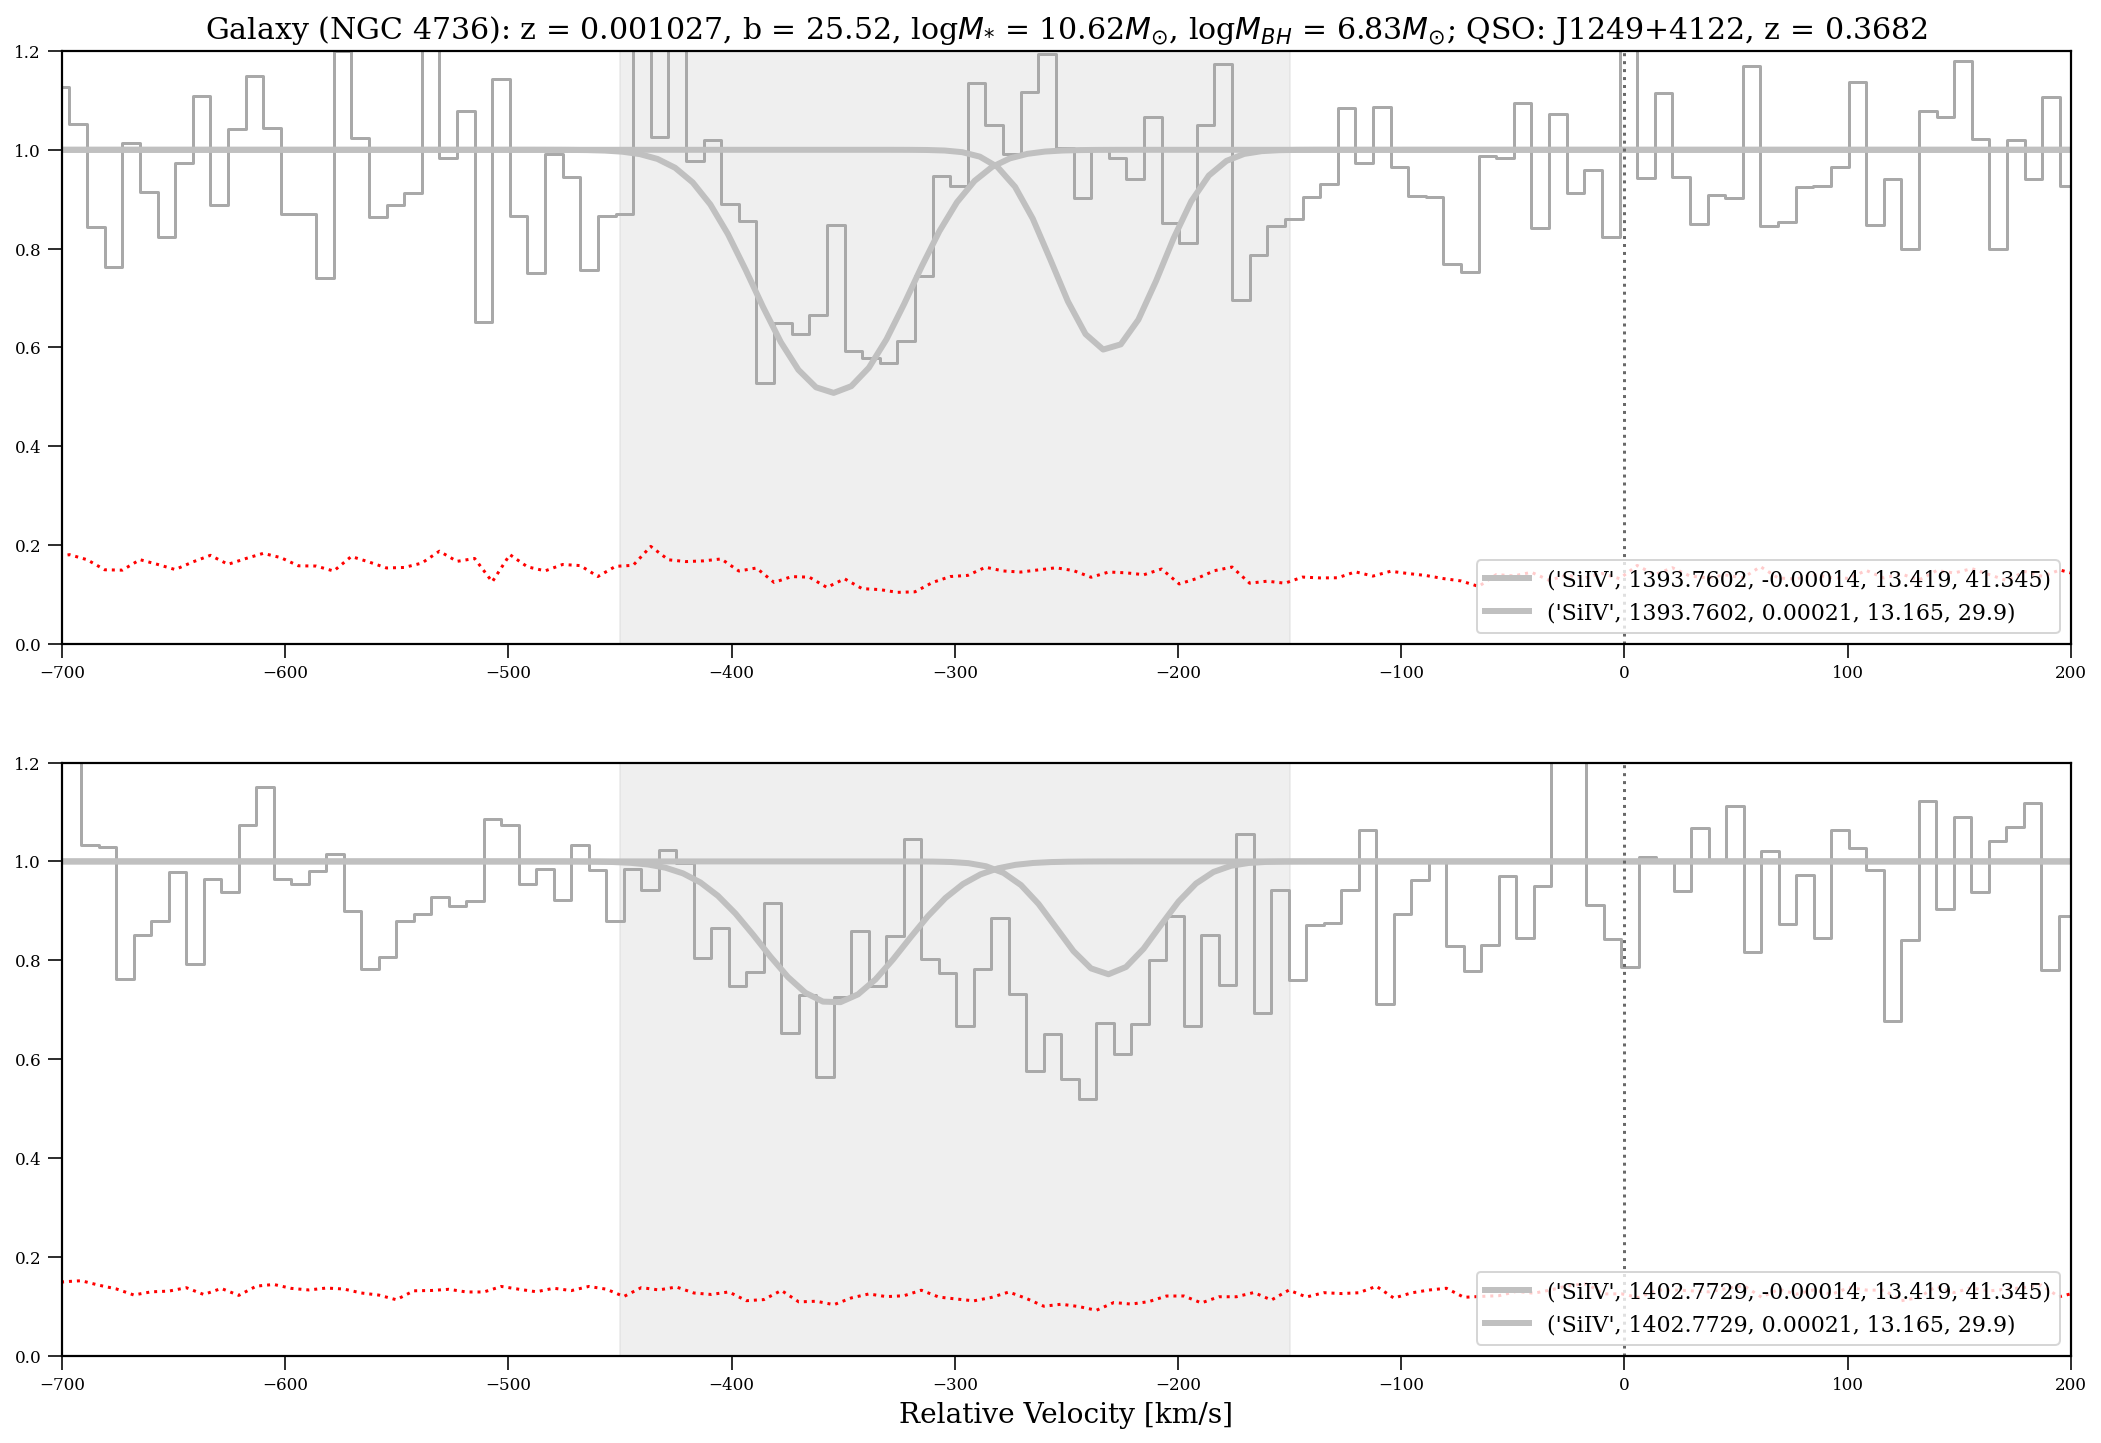

In [45]:
# J1249 - Unsmoothed Spectra 
J1249_vsp(xspec_J1249, Vels_J1249, Voigt_J1249) 
# J1249 - Smoothed Spectra 
#J1249_vsp(smooth_xspec_J1249, Vels_smooth_J1249, Voigt_smooth_J1249)

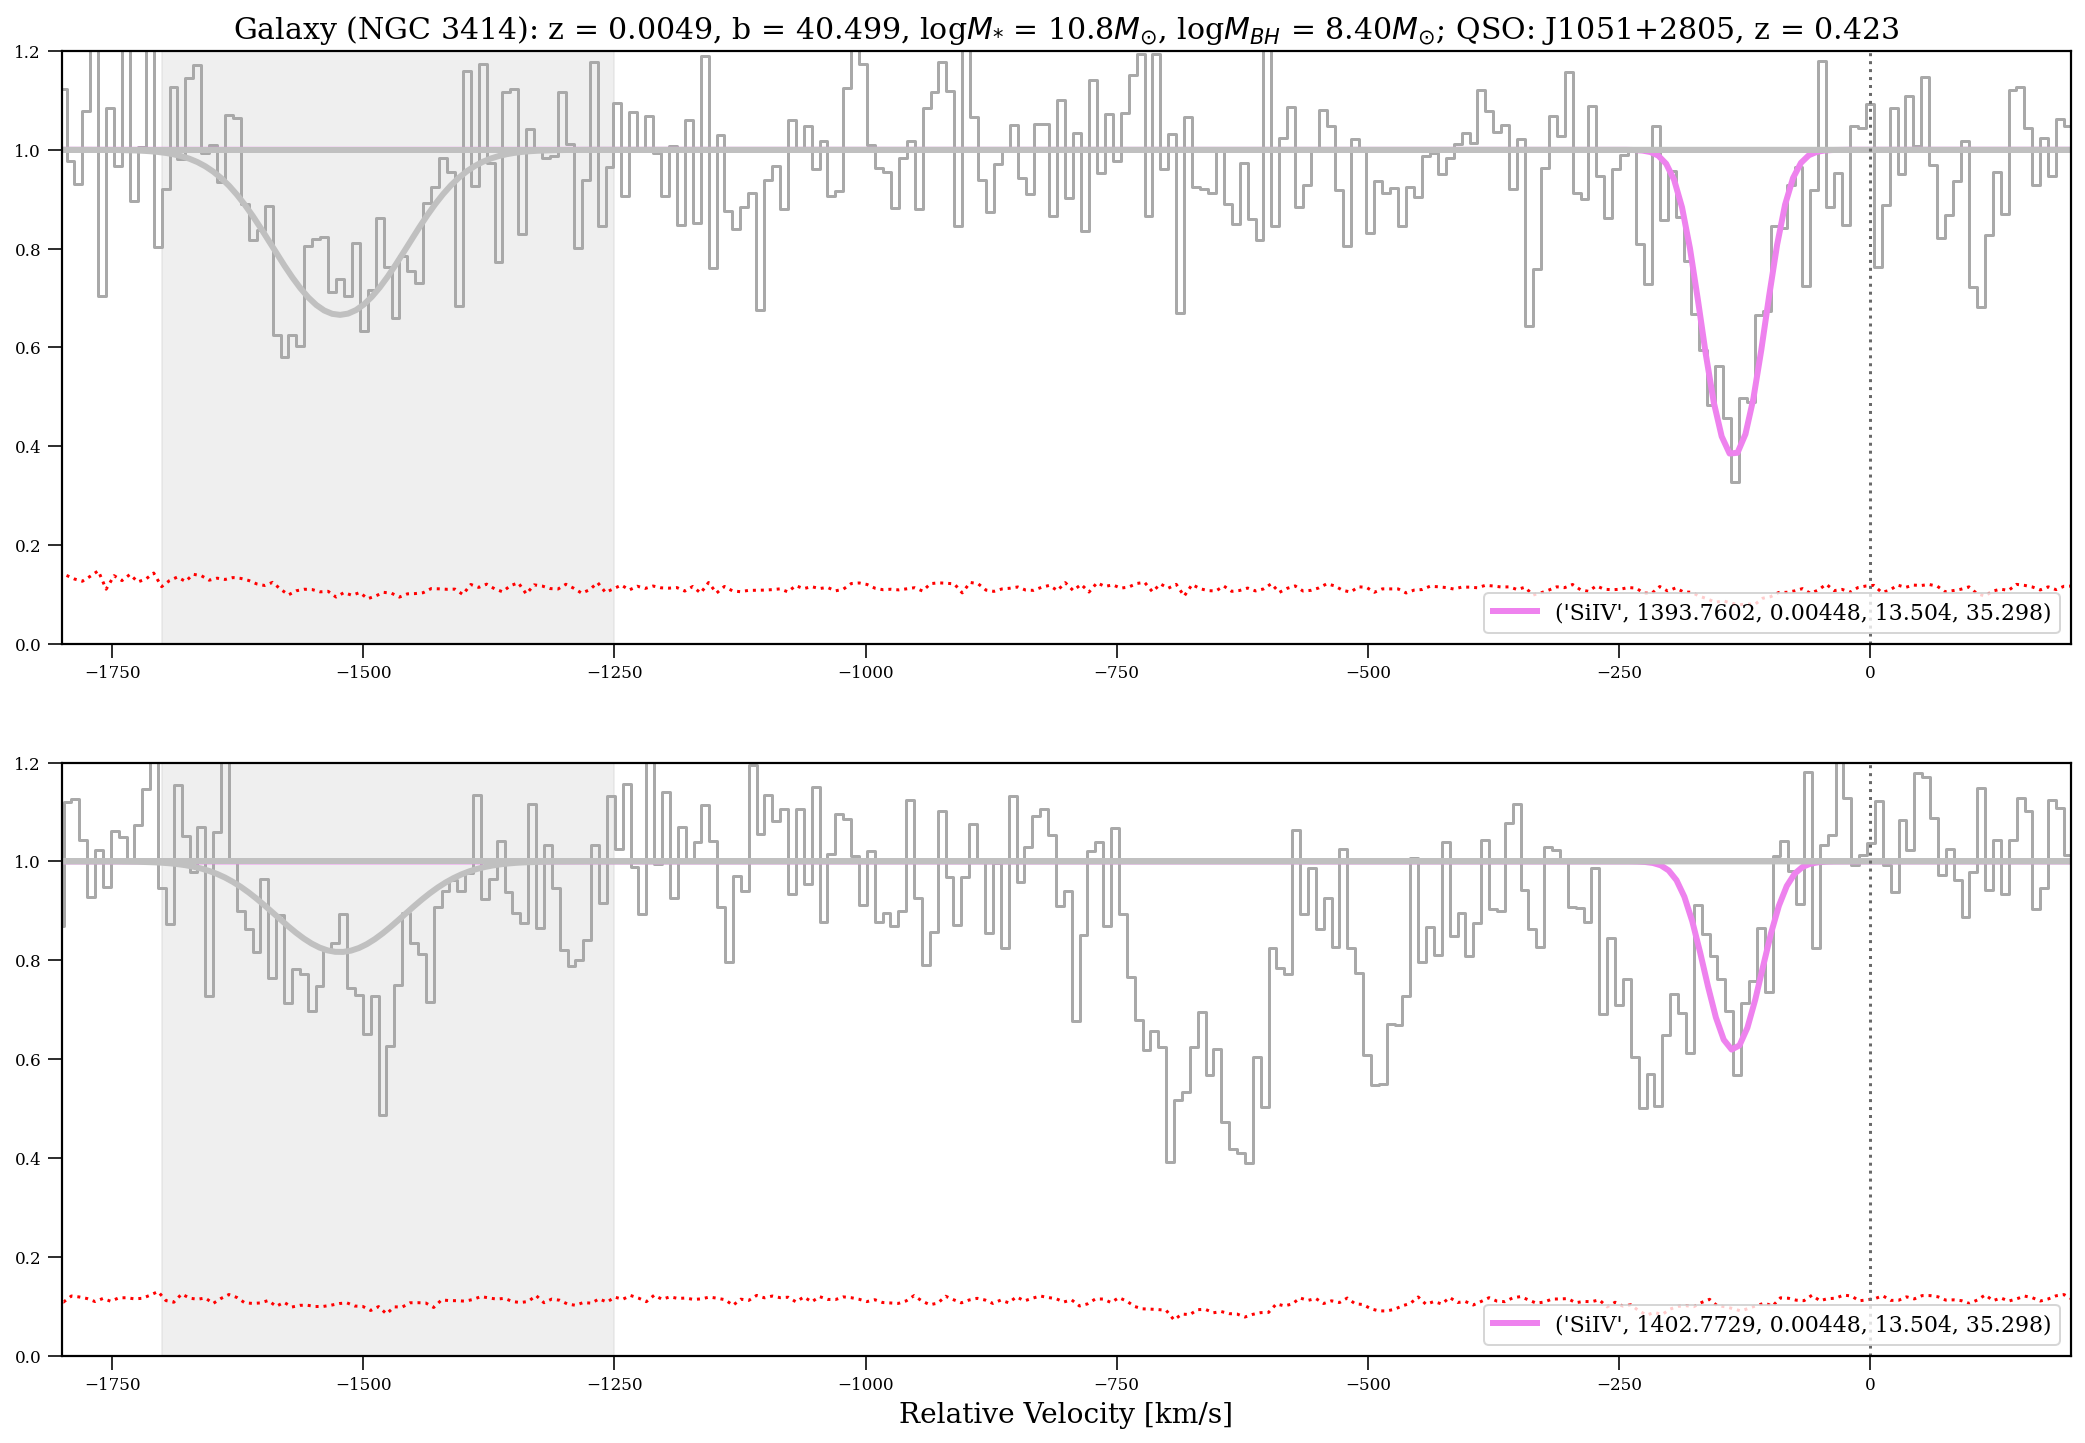

In [46]:
# J1051 - Unsmoothed Spectra 
J1051_vsp(xspec_J1051, Vels_J1051, Voigt_J1051) #one of the features is not plotting, need to look into that 
# J1051 - Smoothed Spectra 
#J1051_vsp(smooth_xspec_J1051, Vels_smooth_J1051, Voigt_smooth_J1051) #one of the features is not plotting, need to look into that 
#for this detection maybe I should be using the information from the 1402 line? 
#Need to talk about this with Jess 

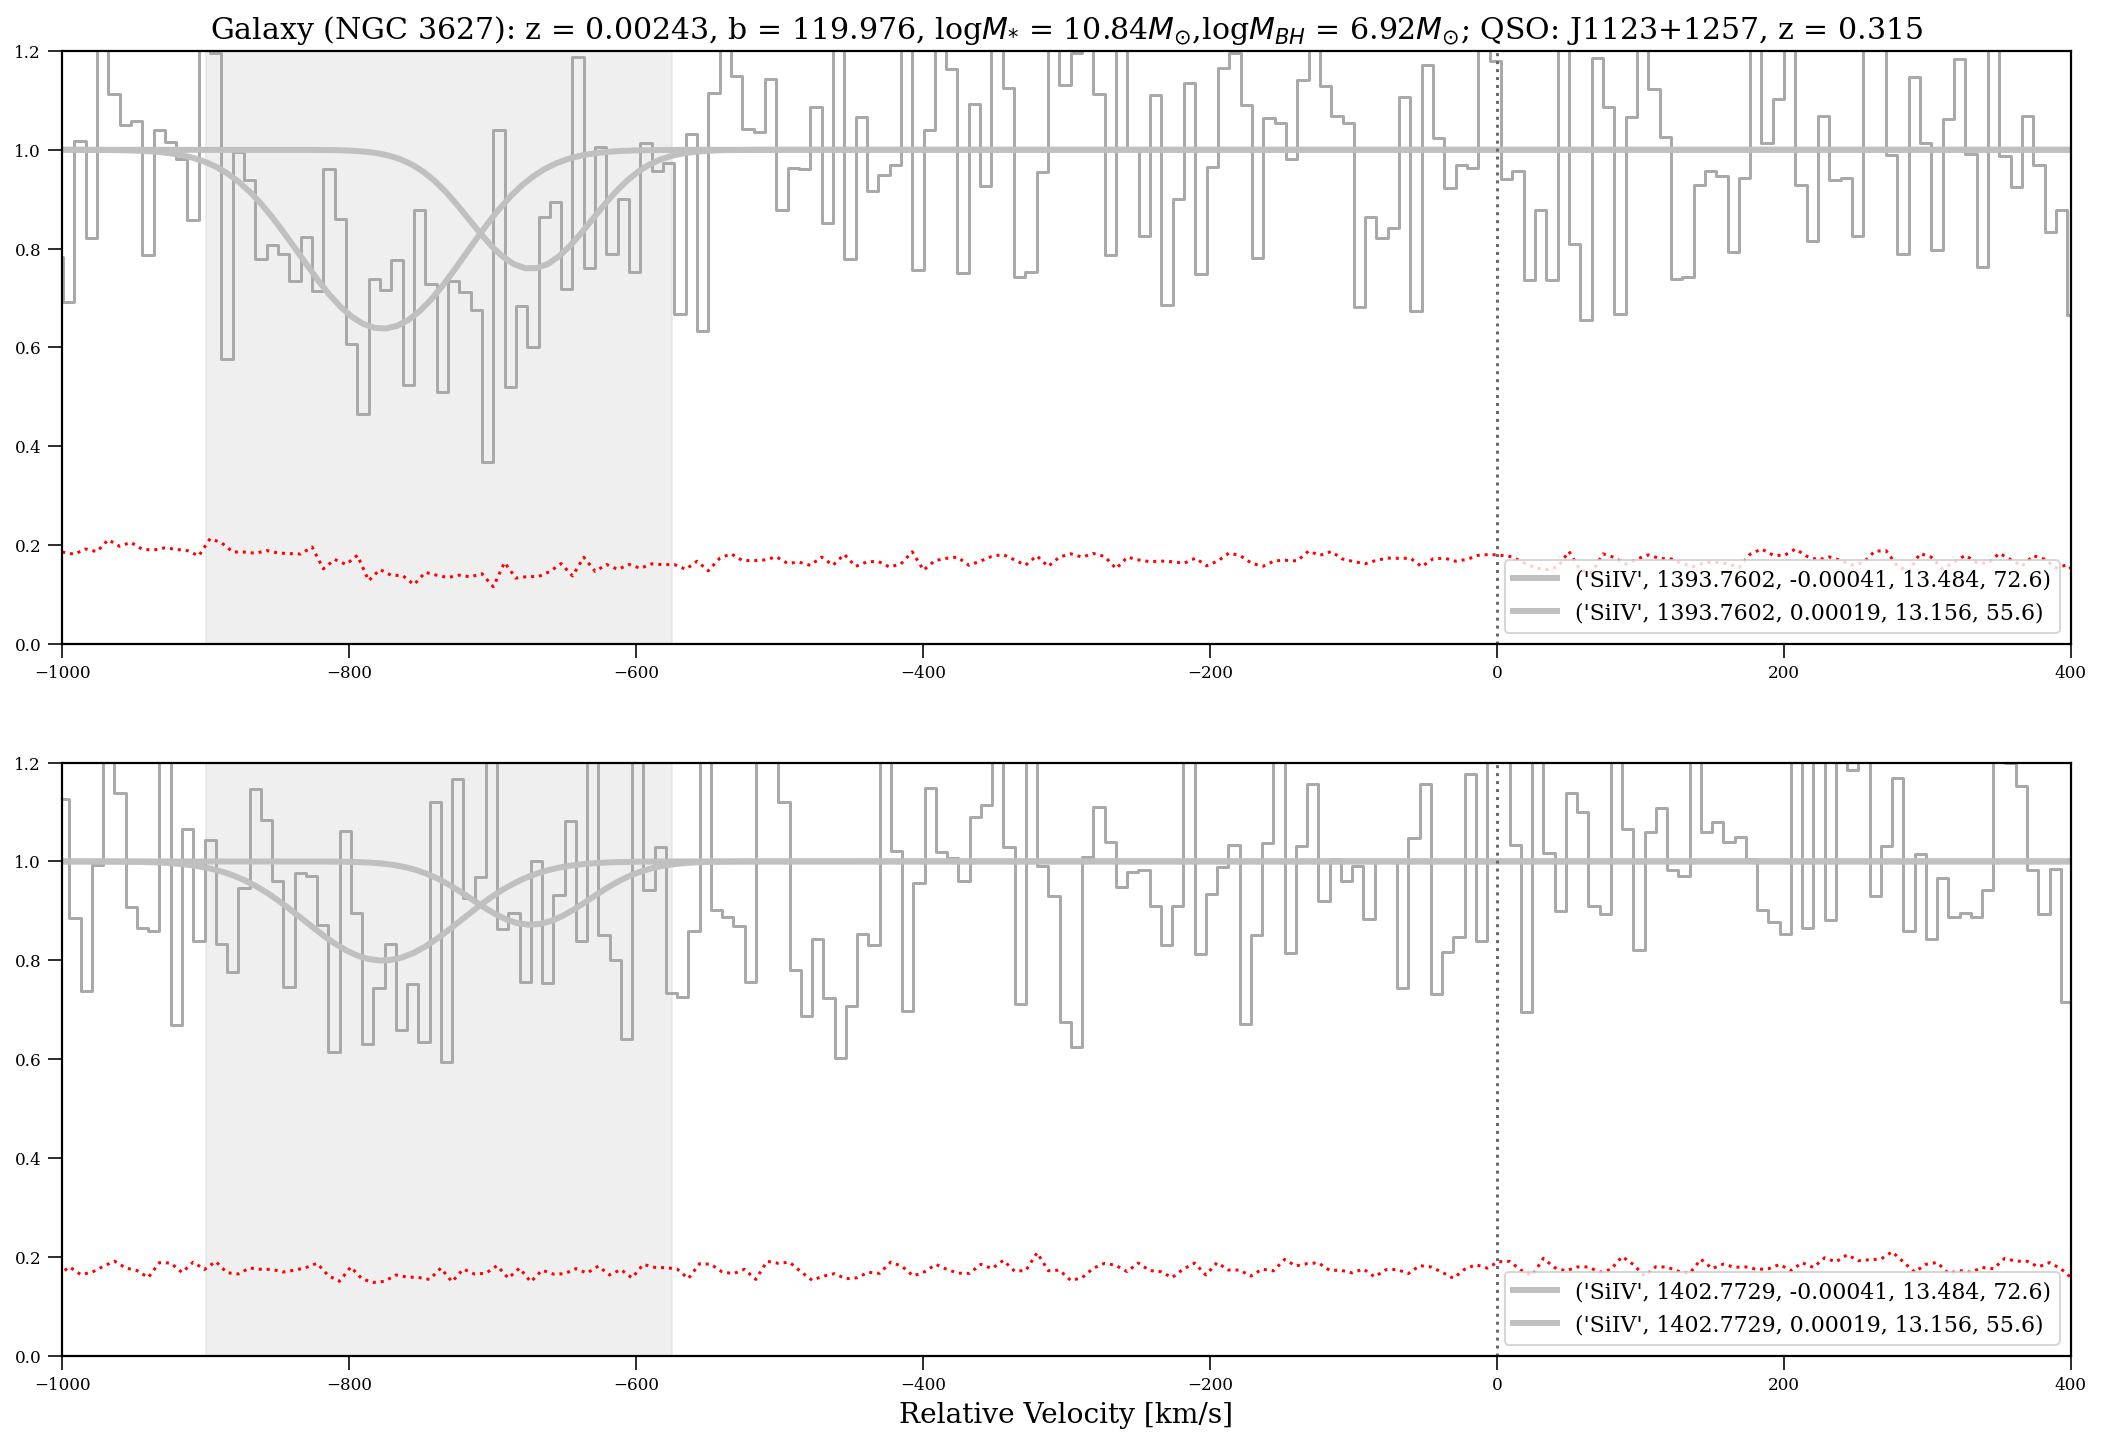

In [47]:
# J1123 - Unsmoothed Spectra 
J1123_vsp(xspec_J1123, Vels_J1123, Voigt_J1123) 
# J1123 - Unsmoothed Spectra 
#J1123_vsp(smooth_xspec_J1123, Vels_smooth_J1123, Voigt_smooth_J1123) 

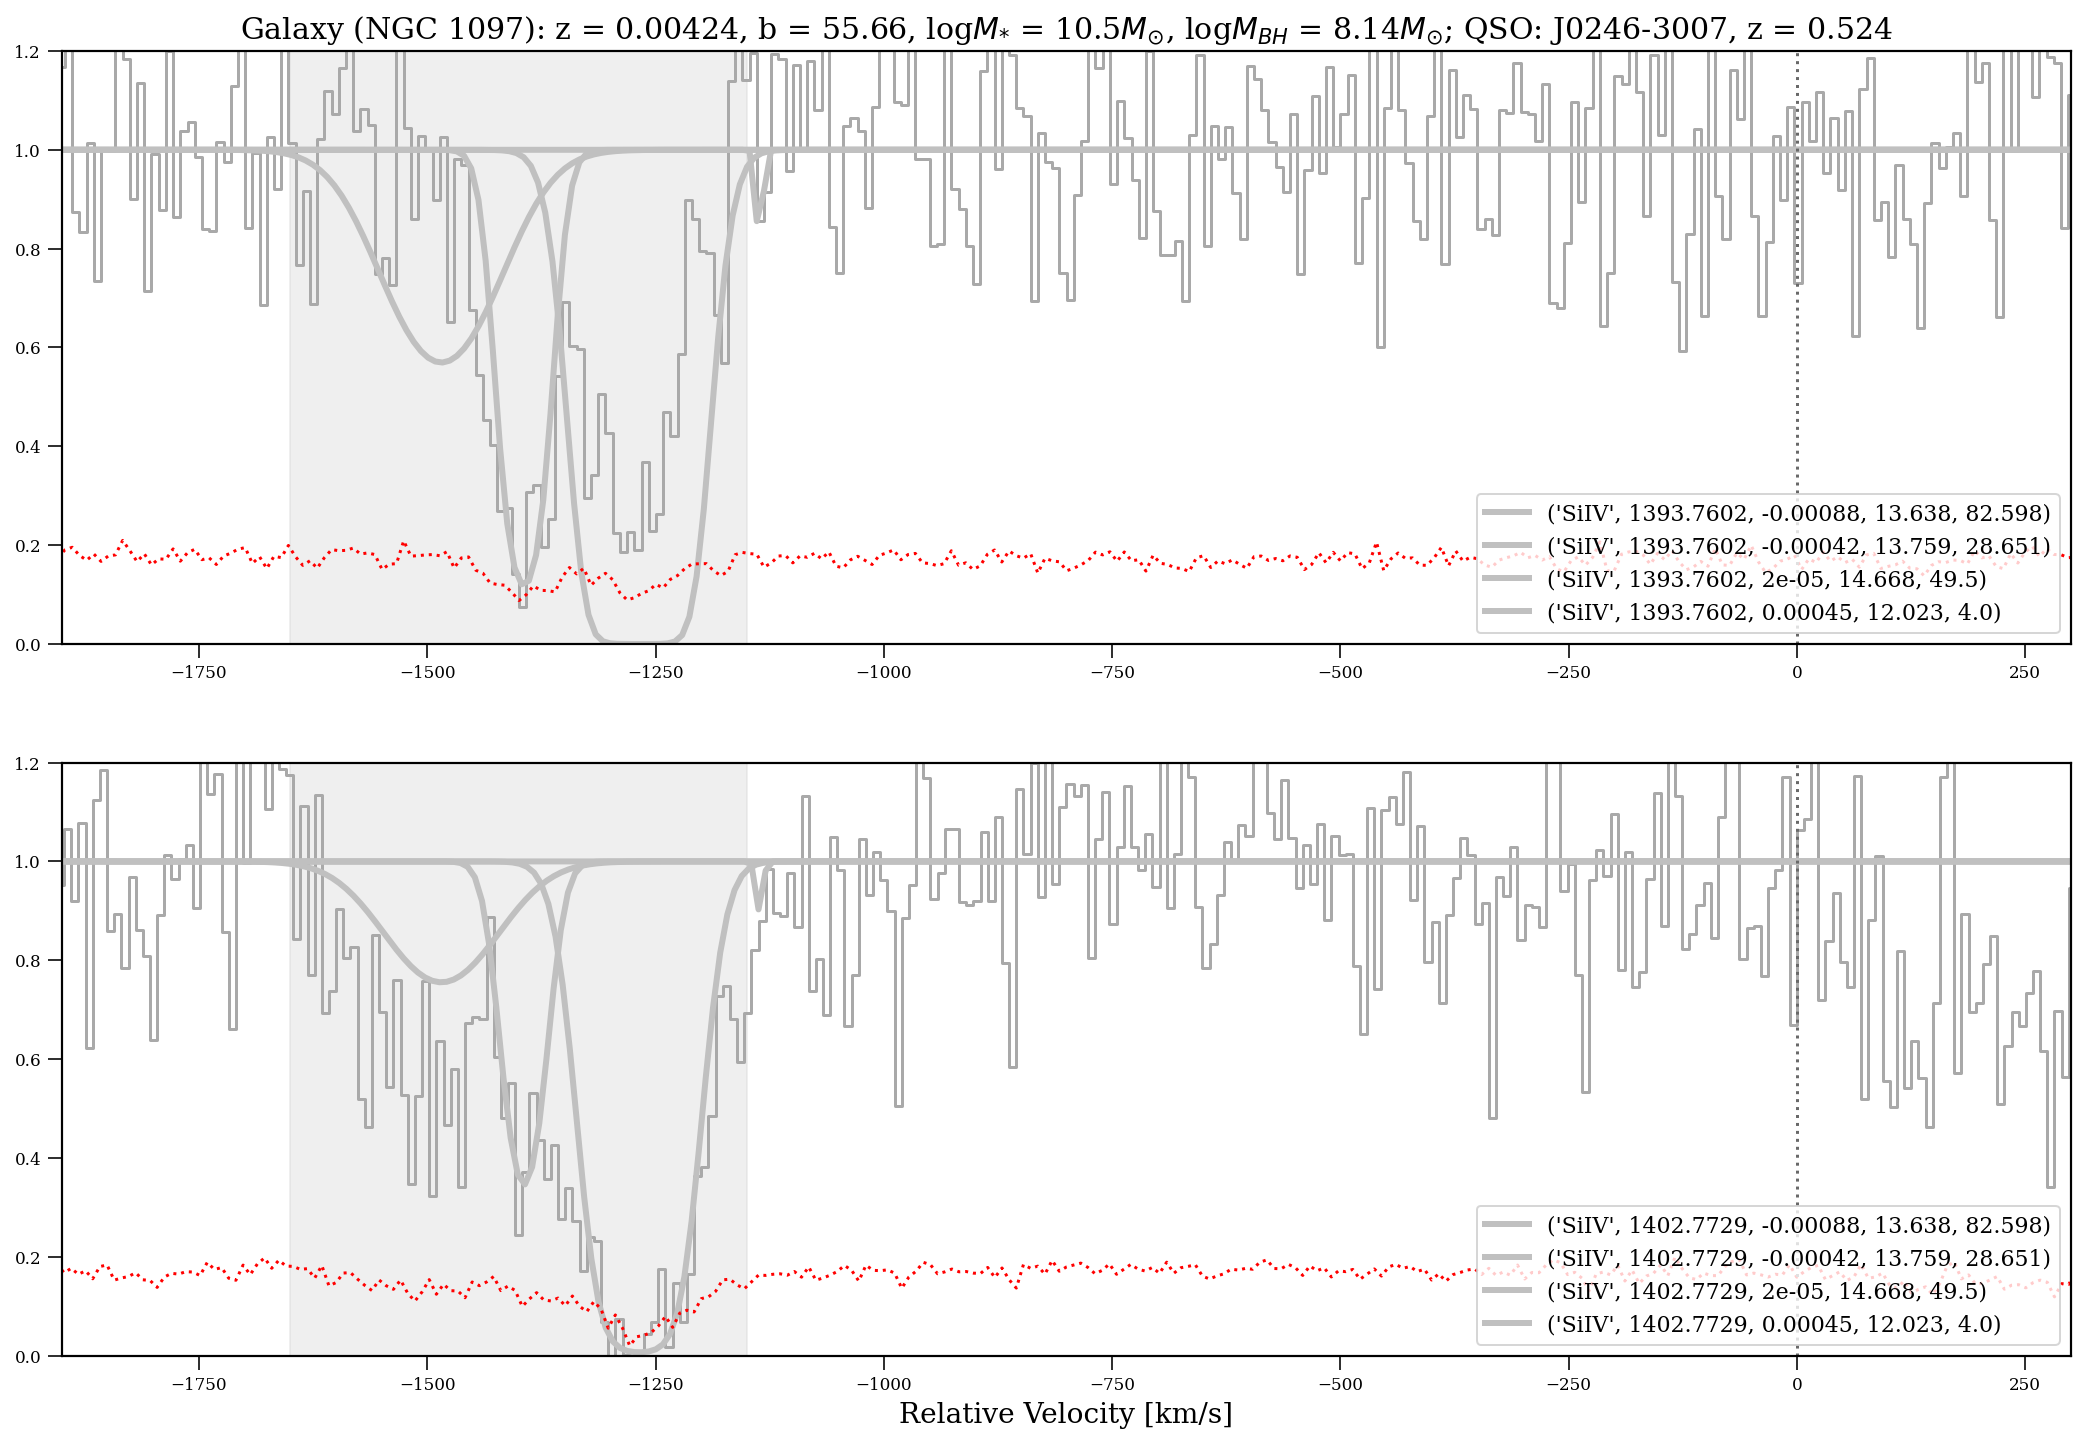

In [48]:
# J0246 - Unsmoothed Spectra 
J0246_vsp(xspec_J0246, Vels_J0246, Voigt_J0246) #some fourth one is not plotting 
# J0246 - Smoothed Spectra 
#J0246_vsp(smooth_xspec_J0246, Vels_smooth_J0246, Voigt_smooth_J0246) #some fourth one is not plotting 

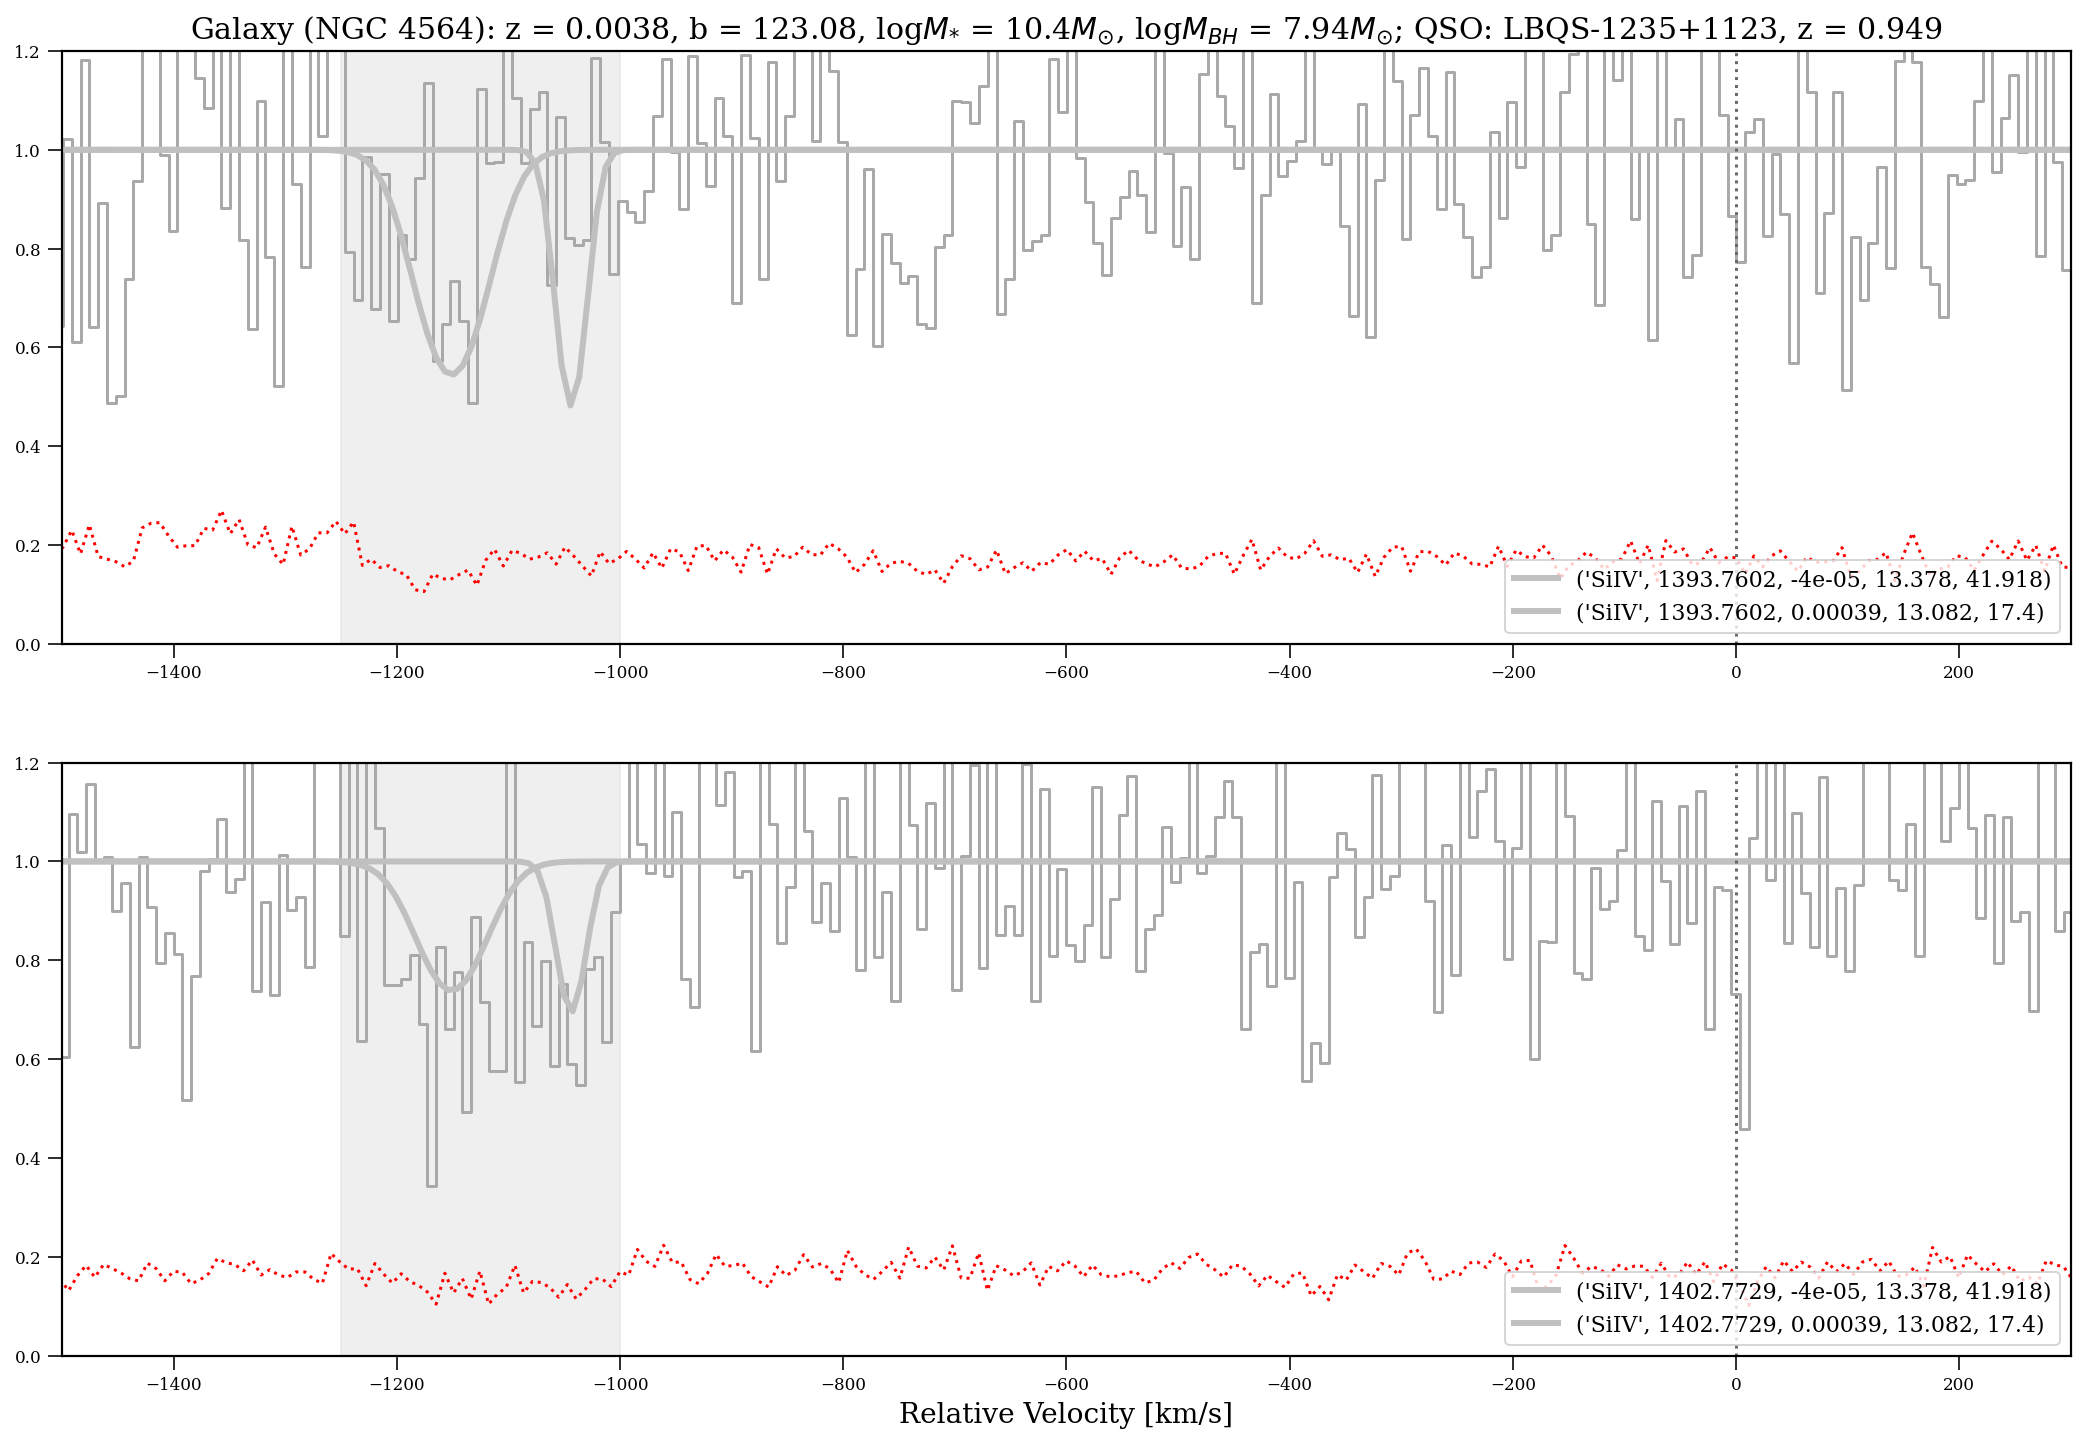

In [49]:
# J1235 - Unsmoothed Spectra 
J1235_vsp(xspec_J1235, Vels_J1235, Voigt_J1235)
# J1235 - Smoothed Spectra 
#J1235_vsp(smooth_xspec_J1235, Vels_smooth_J1235, Voigt_smooth_J1235)